# Double Pendulum Analysis Using NG‑RC with Multiple Initial Conditions


This notebook extends our previous analyses by training the NG‑RC model on a range of initial conditions for the double pendulum. The goal is to capture a wider spectrum of dynamic behaviors by considering diverse starting configurations, which in turn should improve the model's robustness and generalization.

In this notebook, we will:
- Simulate the double pendulum dynamics under various initial conditions.
- Train the NG‑RC model using data from these varied scenarios.
- Construct and combine feature vectors from multiple simulations.
- Validate the trained model using performance metrics and detailed visualizations.

All necessary modules are imported from the `src` folder, ensuring a modular and maintainable code structure.

Next, we will set up the environment and define the parameters for these multiple initial conditions.


In [13]:
import sys
import os

# Add the project root to the system path so that modules in 'src' can be imported
sys.path.append(os.path.abspath('..'))

# Import required modules from the src folder
from src.models.double_pendulum import DoublePendulum
from src.ngrc.ngrc_model import (
    ModelParameters, 
    DatasetDiscretization, 
    FeatureVector, 
    compute_training_prediction, 
    compute_testing_prediction, 
    calculate_metrics, 
    compute_testing_prediction_with_params
)
from src.utils.solver import simulate_dynamic_system
from src.utils.plot_helper import (
    plot_comparison, 
    plot_comparison_only_testing, 
    plot_scatter_comparison, 
    plot_phase_comparison, 
    plot_scatter_comparison_only_testing, 
    plot_phase_comparison_only_testing, 
    plot_W_out, 
    get_feature_labels
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# Update matplotlib parameters for consistent styling
plt.rcParams.update({
    'font.size': 10,
    'lines.linewidth': 0.8,
    'figure.dpi': 300,
    'axes.grid': True,
})


## Define Simulation and Initial Conditions for Multiple Scenarios

In the next cell, we set up the simulation parameters and specify the physical parameters for the double pendulum. We also define arrays of possible initial conditions for the pendulum (angles and angular velocities for both pendulums) and generate all combinations of these initial conditions using `itertools.product`. Finally, we retrieve the double pendulum solver function from the `DoublePendulum` class.


In [15]:
# Simulation parameters
dt = 0.01                                # Time step (seconds)
max_time = 100                           # Total simulation time (seconds)
t_eval = np.linspace(0, max_time, round(max_time / dt) + 1)

# Physical parameters for the double pendulum
G = 9.8        # Gravitational acceleration (m/s²)
L1 = 1         # Length of first pendulum (m)
L2 = 1         # Length of second pendulum (m)
M1 = 1         # Mass of first pendulum (kg)
M2 = 1         # Mass of second pendulum (kg)
params = (L1, L2, M1, M2, G)

# Define arrays of initial conditions (in degrees)
theta1_array = [30.0, 40.0, 50.0, 60.0, 70.0]  # Possible angles for pendulum 1
omega1_array = [0.0, 0.5, 1.0]                  # Possible angular velocities for pendulum 1
theta2_array = [20.0, 30.0, 40.0, 50.0, 60.0]  # Possible angles for pendulum 2
omega2_array = [0.0, 0.5, 1.0]                  # Possible angular velocities for pendulum 2

# Generate all combinations of initial conditions (in degrees)
states_array_deg = list(itertools.product(theta1_array, omega1_array, theta2_array, omega2_array))

# Retrieve the double pendulum solver method from the DoublePendulum class
double_pendulum_solver = DoublePendulum.double_pendulum_solve_ivp

## Training with Multiple Initial Conditions

In this cell, we train the NG‑RC model using a variety of initial conditions generated previously. For each initial conditis), we perform the following steps:

- Convert the initial state from degrees to radians.
- Simulate the double pendulum dynamics using our ODE solver.
- Configure the NG‑RC model by creating a `ModelParameters` object and discretizing the dataset.
- Build the feature vectors (both linear and full) from the simulation data.
- Compute the difference solution (the difference between consecutive values in the linear feature vector) for the first few state variables.
- Store the full feature vector and the difference solution in a dictionary.

After processing all initial conditions, we concatenate the difference solutions and full feature vectors from every simulation. Finally, we compute the output weight matrix (`W_out`) using ridge regression. This matrix will later be used for prediction.


In [19]:
# --------------------- NG‑RC Training with Multiple Initial Conditions ---------------------

# NG‑RC configuration parameters
polynomial_order = 3
input_dimension = 4
delay_taps = 3
include_constant = False
ridge_regression = 1.0e-3
including_all_pol_combination = True

# Set training and testing percentages (100% training, 0% testing)
train_percentage = 100 
test_percentage = 0

# Dictionary to store the solutions for each set of initial conditions
solutions_dict = {}
count_solutions = 0

# Loop over all combinations of initial conditions (states_array_deg)
for state_deg in states_array_deg:
    # Convert the initial state from degrees to radians
    initial_state = np.radians(state_deg)
    
    # Simulate the double pendulum dynamics using the solver
    pendulum_states, time_array = simulate_dynamic_system(
        double_pendulum_solver, initial_state, params, dt, max_time
    )
    
    # Configure the NG‑RC model parameters
    model_params = ModelParameters(
        polynomial_order=polynomial_order,
        input_dimension=input_dimension,
        delay_taps=delay_taps,
        include_constant=include_constant,
        ridge_regression=ridge_regression
    )
    
    # Create dataset discretization (100% training for this simulation)
    dataset_disc = DatasetDiscretization(
        model_params, 
        time_array, 
        train_percentage=train_percentage, 
        test_percentage=test_percentage
    )
    
    # Build the feature vector object for NG‑RC training
    feature_vec_obj = FeatureVector(
        model_params, 
        pendulum_states, 
        dataset_disc,
        including_all_pol_combination=including_all_pol_combination
    )
    
    # Extract discretization indices and related parameters
    warmup = dataset_disc.warmup_pts()
    warmup_train = dataset_disc.warmup_train_pts()
    train_pts = dataset_disc.train_pts()
    test_pts = dataset_disc.test_pts()
    input_dim = model_params.input_dimension
    ridge_param = model_params.ridge_regression
    
    # Build the linear feature vector from the simulation data
    linear_vector = feature_vec_obj.build_linear_feature_vector()
    # Build the full feature vector (including nonlinear terms)
    full_vector = feature_vec_obj.build_full_feature_vector(linear_vector)
    
    # Compute the difference between consecutive values for the first 'input_dim' features
    diff_solution = linear_vector[0:input_dim, warmup:warmup_train] - \
                    linear_vector[0:input_dim, warmup - 1:warmup_train - 1]
    
    dtot = full_vector.shape[0]
    
    # Store the full feature vector and difference solution in a dictionary
    solution_dict = {
        'full_feature_vec': full_vector,
        'diff_sol_values': diff_solution
    }
    
    solutions_dict[count_solutions] = solution_dict
    count_solutions += 1

# Concatenate the difference solutions from all simulations along the columns
tuple_diff_sol_values = tuple(sol['diff_sol_values'] for sol in solutions_dict.values())
concat_diff_sol_values = np.concatenate(tuple_diff_sol_values, axis=1)

# Concatenate the full feature vectors from all simulations along the columns
tuple_full_feature_vec = tuple(sol['full_feature_vec'] for sol in solutions_dict.values())
concat_full_feature_vec = np.concatenate(tuple_full_feature_vec, axis=1)

# Compute the output weights (W_out) using ridge regression
W_out = concat_diff_sol_values @ concat_full_feature_vec.T @ np.linalg.pinv(
    concat_full_feature_vec @ concat_full_feature_vec.T + ridge_param * np.identity(dtot)
)


## NG‑RC Prediction Configuration for a New Scenario

In this cell, we configure the NG‑RC prediction setup for a scenario not used during training. We:
- Define new initial conditions (converted from degrees to radians) for the double pendulum.
- Simulate the pendulum dynamics using the ODE solver.
- Configure the NG‑RC model parameters and dataset discretization (with 0% training and 100% testing).
- Build the linear feature vector and calculate the total variance.
- Extract discretization indices and related parameters for subsequent prediction steps.


In [24]:
# --------------------- NG‑RC PREDICTION CONFIGURATION ---------------------

# New initial conditions for prediction (angles in degrees, converted to radians)
th1, w1 = 32.4, 0.2
th2, w2 = 55.5, 0.7
predict_initial_state = np.radians([th1, w1, th2, w2])

# Simulate the double pendulum dynamics for the new initial condition
# (This simulation is used for prediction and to estimate Lyapunov time if needed)
pendulum_states, time_array = simulate_dynamic_system(
    double_pendulum_solver, 
    predict_initial_state, 
    params, 
    dt, 
    max_time
)

# -------------------------- NG‑RC CONFIGURATION FOR PREDICTION --------------------------
# Create NG‑RC model parameters (same as training configuration)
model_params = ModelParameters(
    polynomial_order=polynomial_order,
    input_dimension=input_dimension,
    delay_taps=delay_taps,
    include_constant=include_constant,
    ridge_regression=ridge_regression
)

# Discretize the dataset for prediction (0% training, 100% testing)
dataset_disc = DatasetDiscretization(
    model_params, 
    time_array, 
    train_percentage=0, 
    test_percentage=100
)

# Build the feature vector object for NG‑RC prediction
feature_vec_obj = FeatureVector(
    model_params, 
    pendulum_states, 
    dataset_disc,
    including_all_pol_combination=including_all_pol_combination
)

# Construct the linear feature vector from the prediction simulation data
linear_vector = feature_vec_obj.build_linear_feature_vector()

# Calculate total variance from the simulation data (across all state variables)
total_variance = pendulum_states.var(axis=1).sum()

# Extract discretization indices and parameters needed for prediction
warmup = dataset_disc.warmup_pts()
warmup_train = dataset_disc.warmup_train_pts()
train_pts = dataset_disc.train_pts()
test_pts = dataset_disc.test_pts()
input_dim = model_params.input_dimension
ridge_param = model_params.ridge_regression

x_test = compute_testing_prediction(linear_vector, feature_vec_obj, W_out, warmup_train, test_pts, input_dim)
y_true_test = linear_vector[0:input_dim, warmup_train - 1:-1]
y_pred_test = x_test[0:input_dim, :]
t_test = time_array[warmup_train - 1:-1]

## Validate Results with Metrics and Plots

In the next cell, we perform two main tasks:

1. **Performance Metrics Calculation:**  
   - We calculate key performance metrics (RMSE, NRMSE, MAE, R², and MAPE) using the NG‑RC's `calculate_metrics` function.
   - The computed metrics are then organized into a DataFrame and printed to the console.

2. **Results Visualization:**  
   - We generate multiple plots to validate the NG‑RC predictions:
     - A full comparison plot for the testing phase.
     - A scatter plot comparing selected properties (e.g., the first and third variables).
     - A phase plot for specific variabl NG‑RC model.


In [26]:
metrics_test = calculate_metrics(y_true_test, y_pred_test, total_variance)

metrics_df = pd.DataFrame({
    "Fase": ["Teste"],
    "RMSE": [metrics_test["RMSE"]],
    "NRMSE": [metrics_test["NRMSE"]],
    "MAE": [metrics_test["MAE"]],
    "R²": [metrics_test["R2"]],
    "MAPE (%)": [metrics_test["MAPE (%)"]]
})
print("\nMétricas de desempenho:")
print(metrics_df.to_string())


Métricas de desempenho:
    Fase      RMSE     NRMSE       MAE        R²   MAPE (%)
0  Teste  0.258789  0.136286  0.165337  0.925718  695.37325


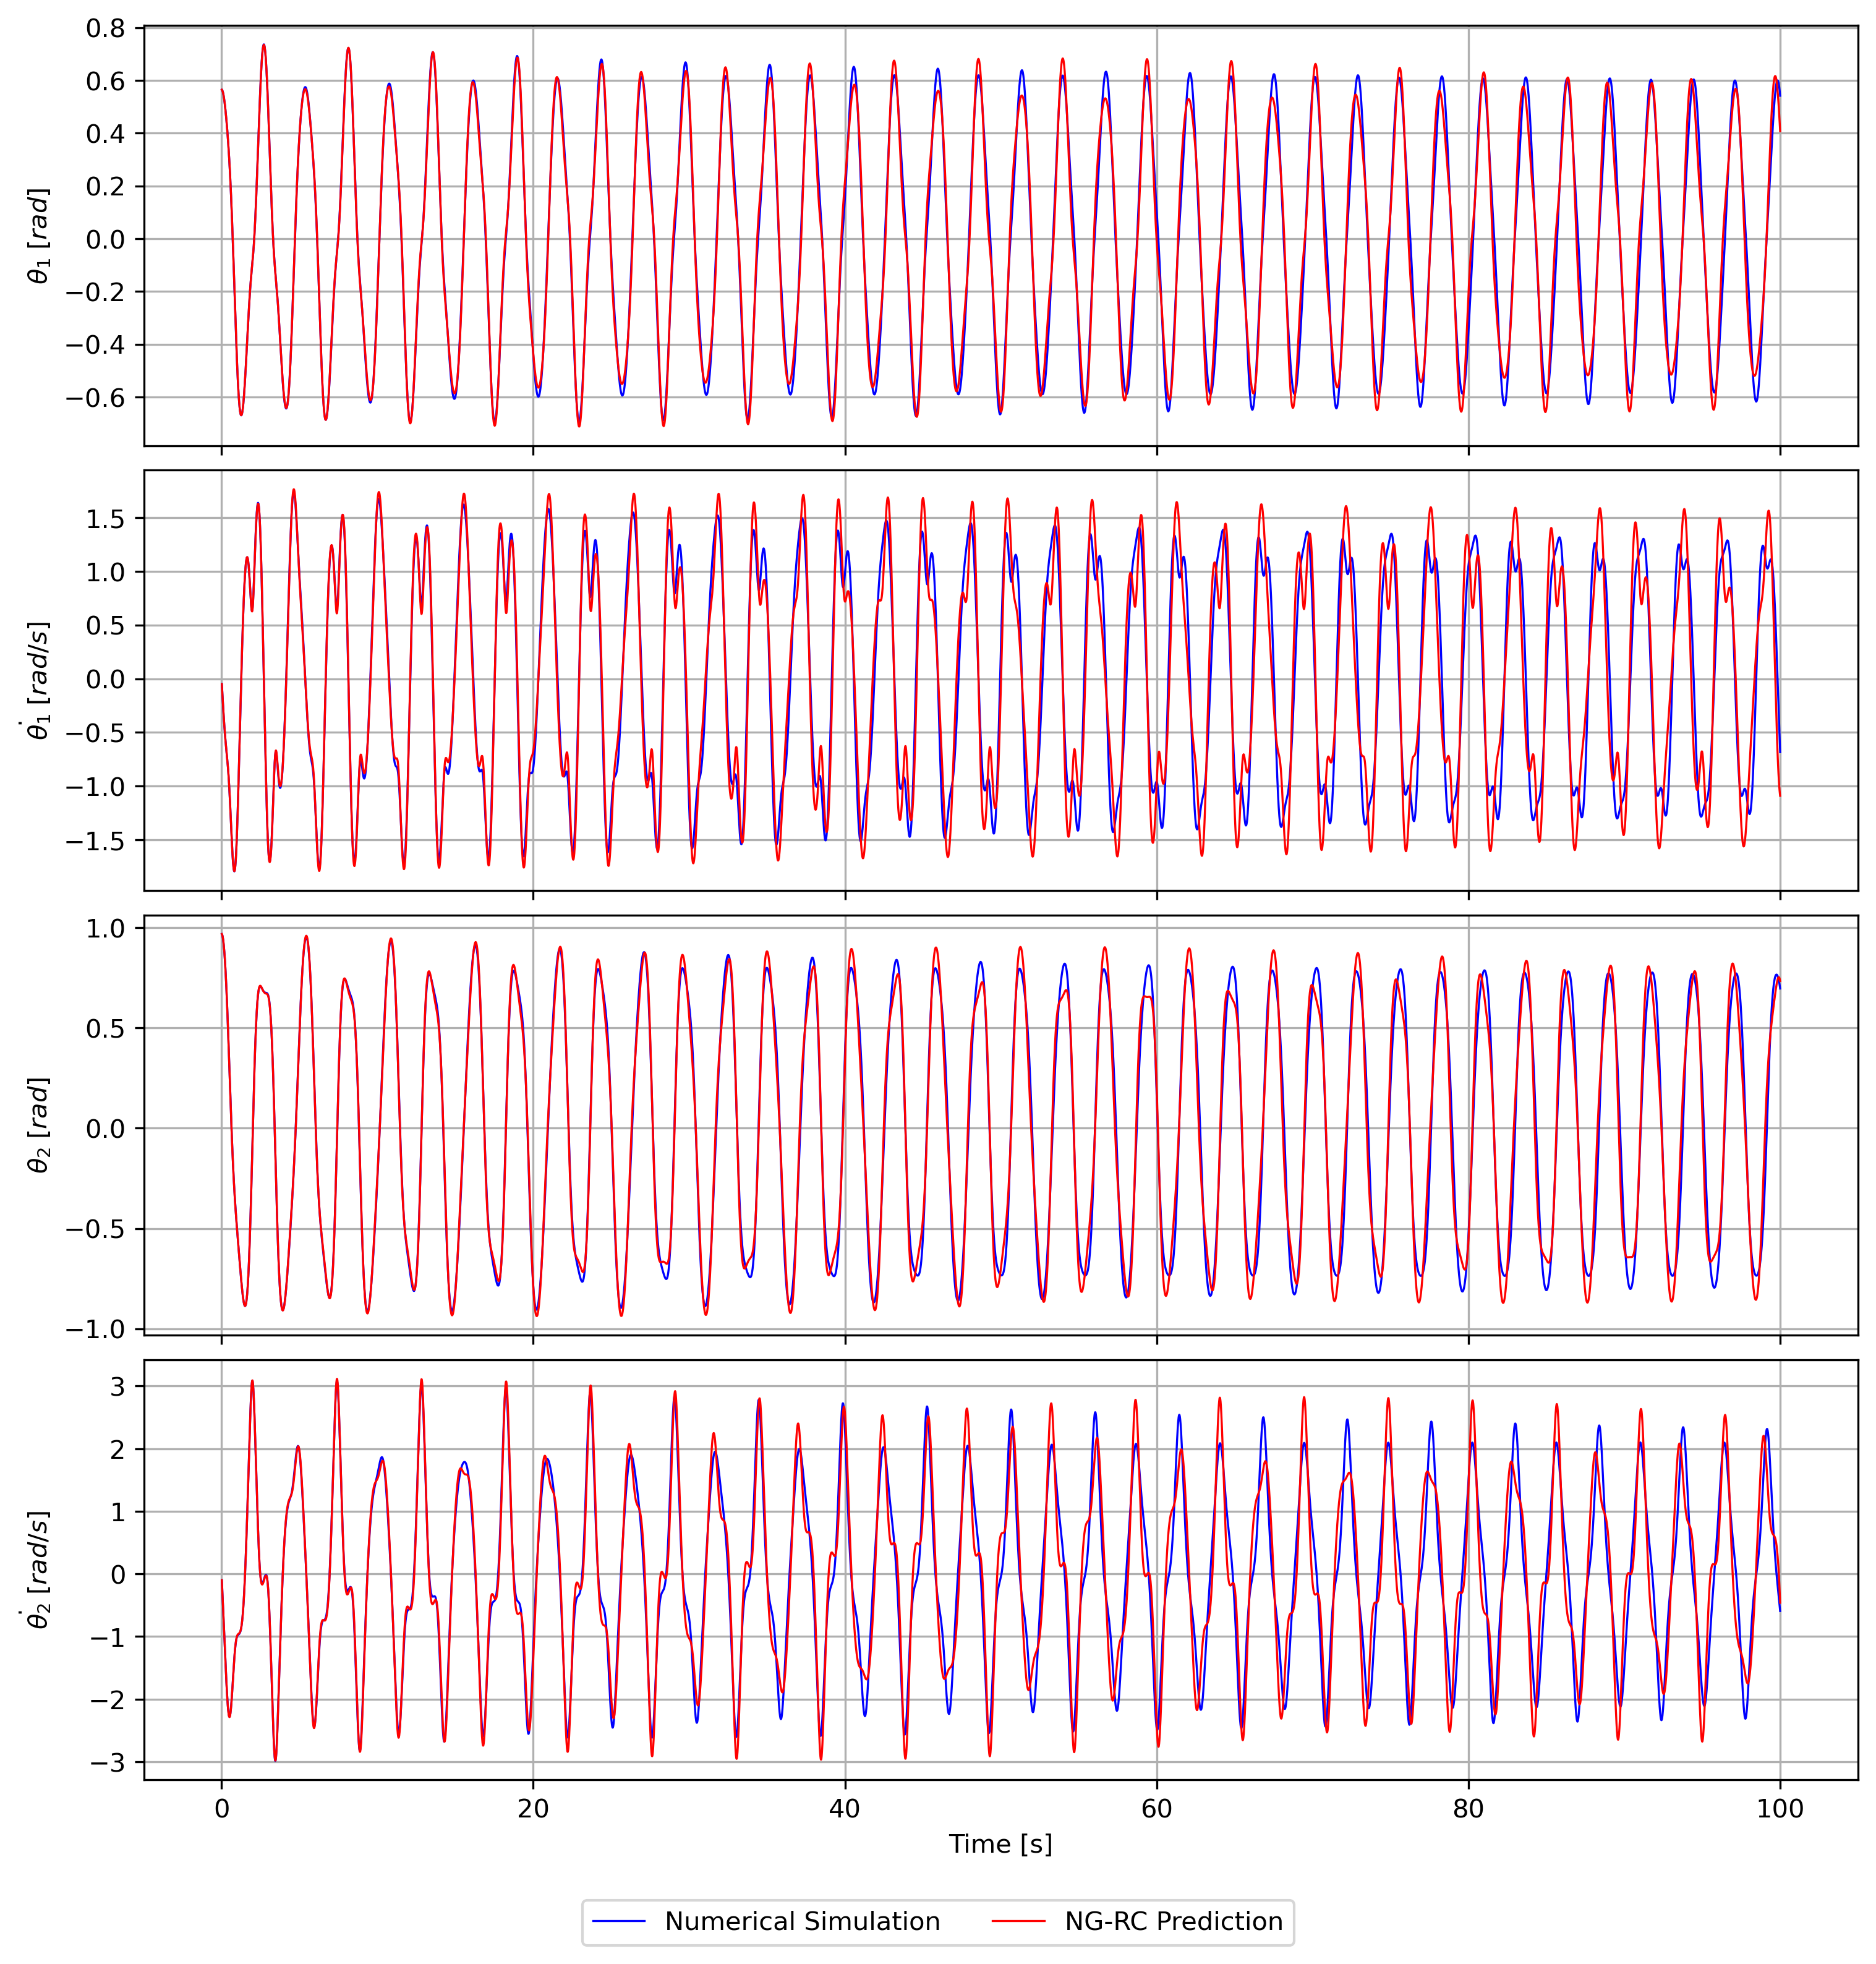

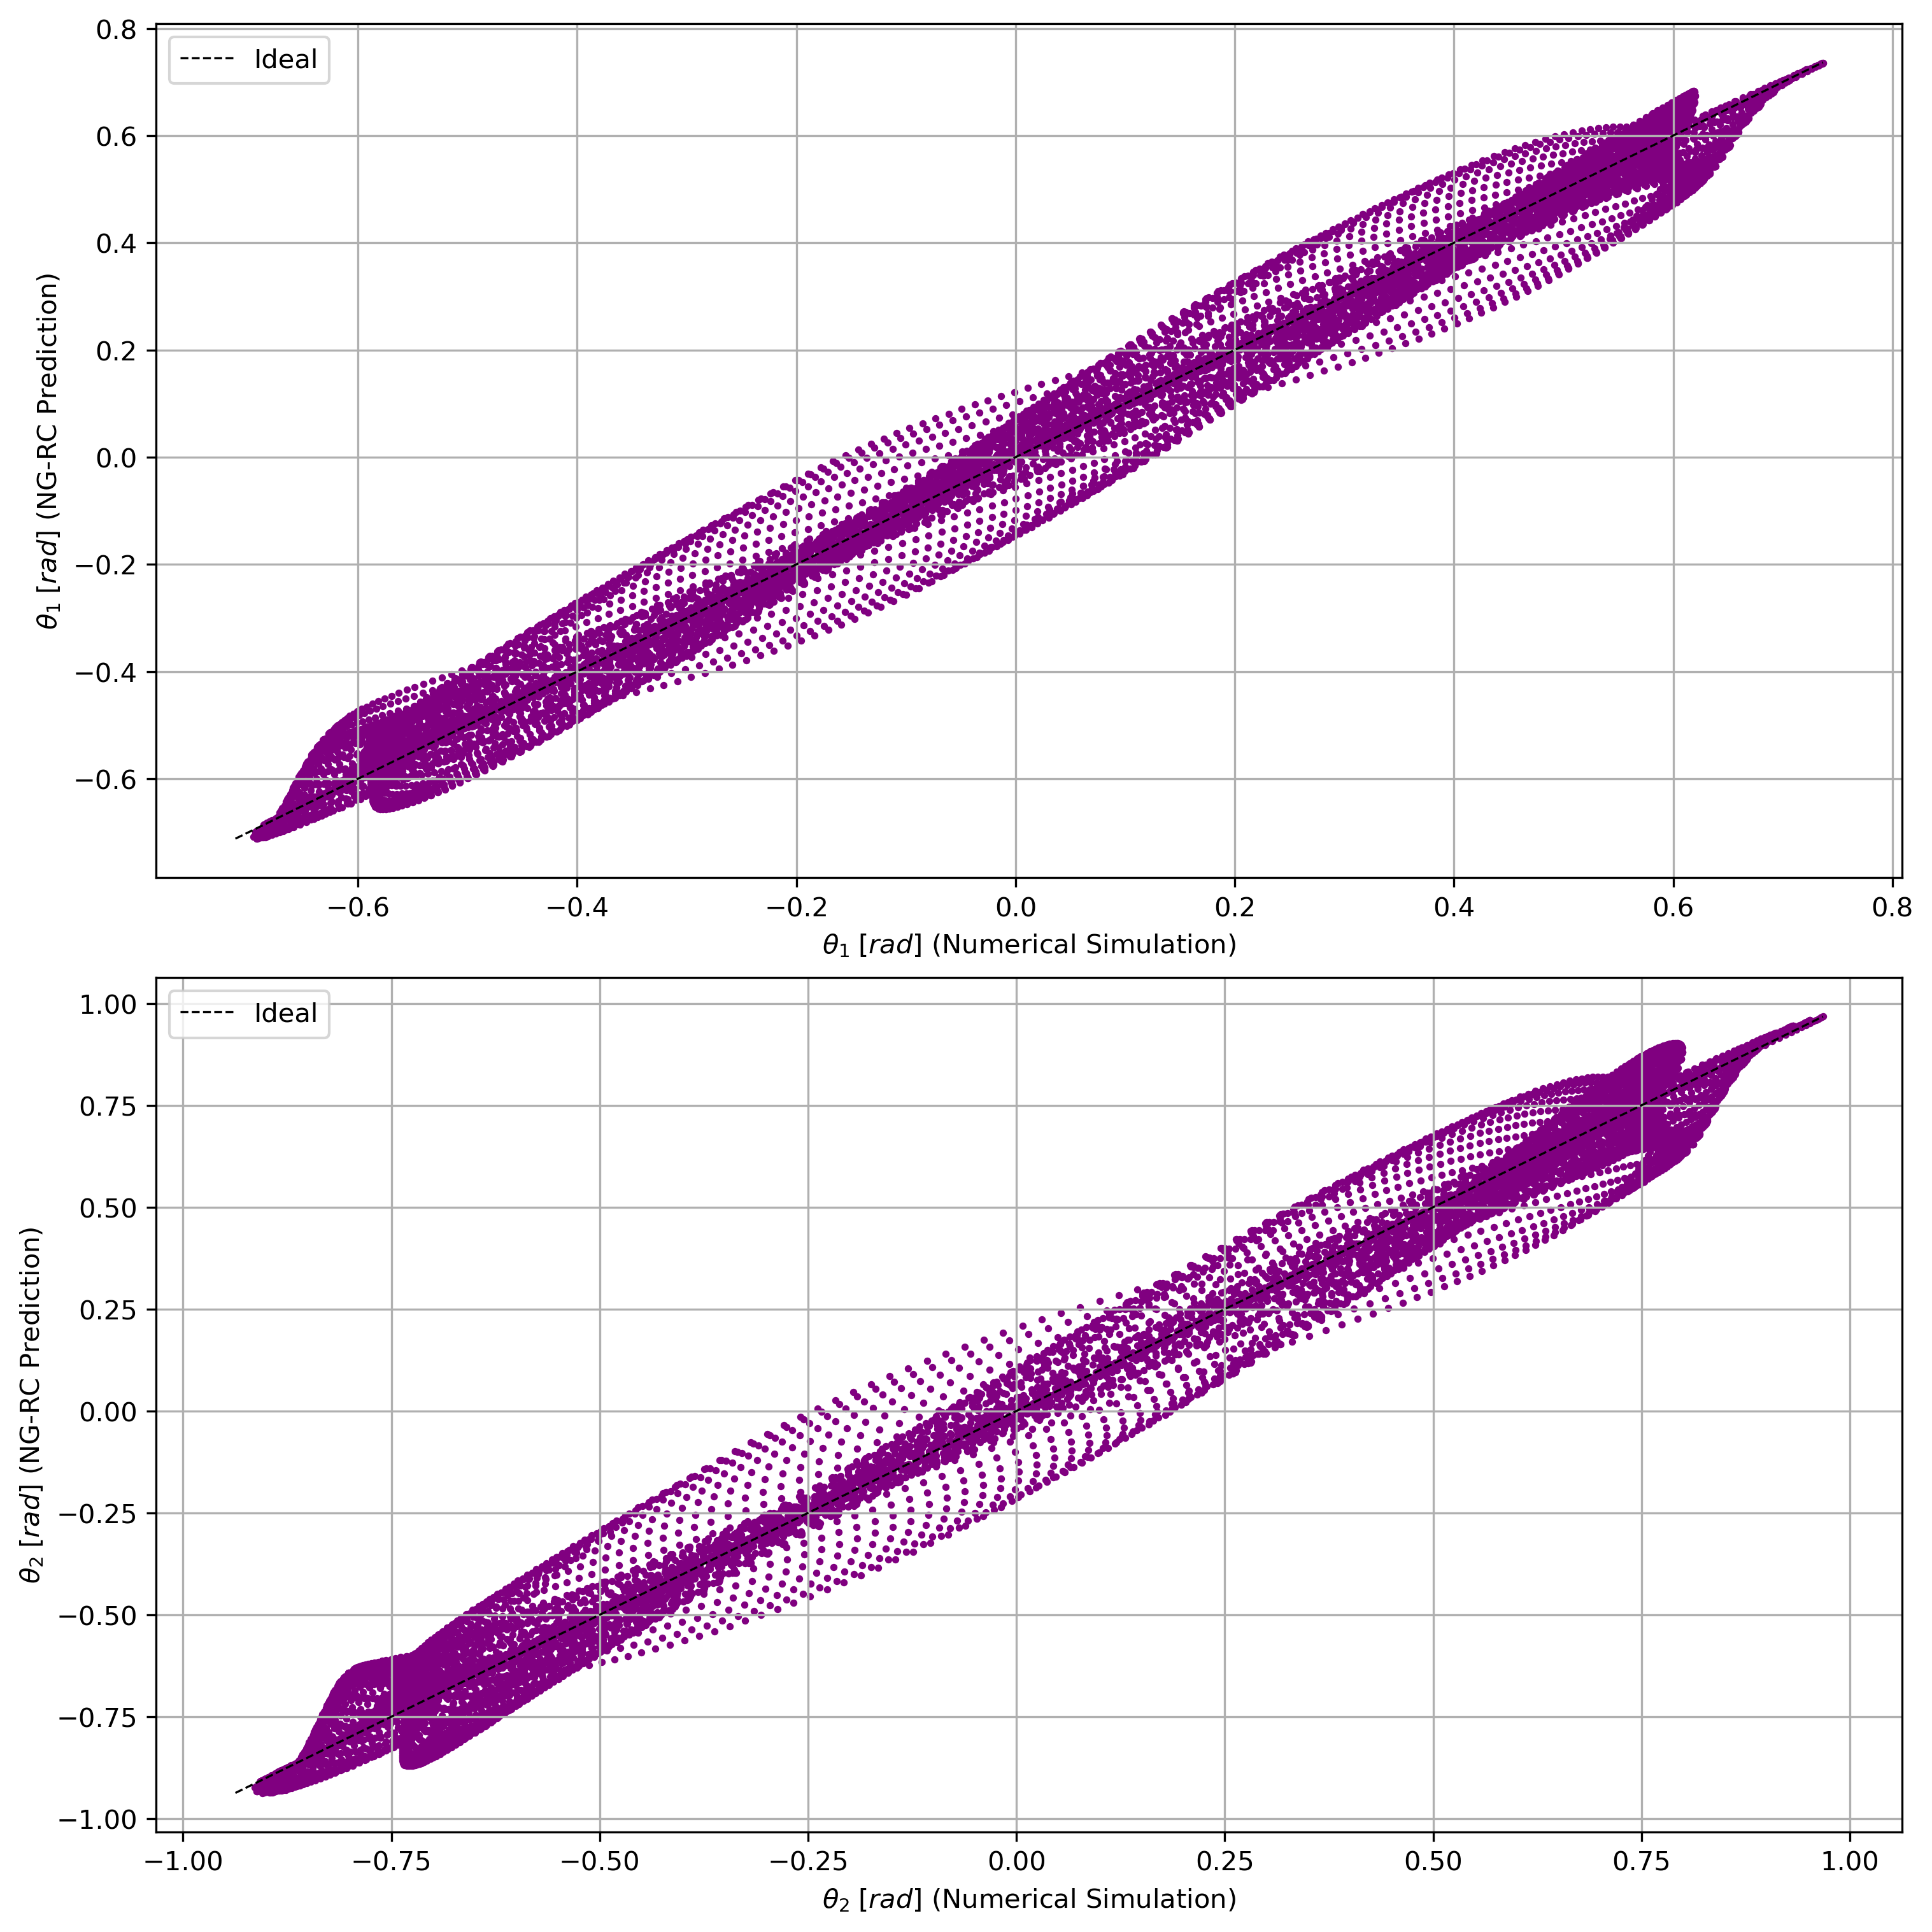

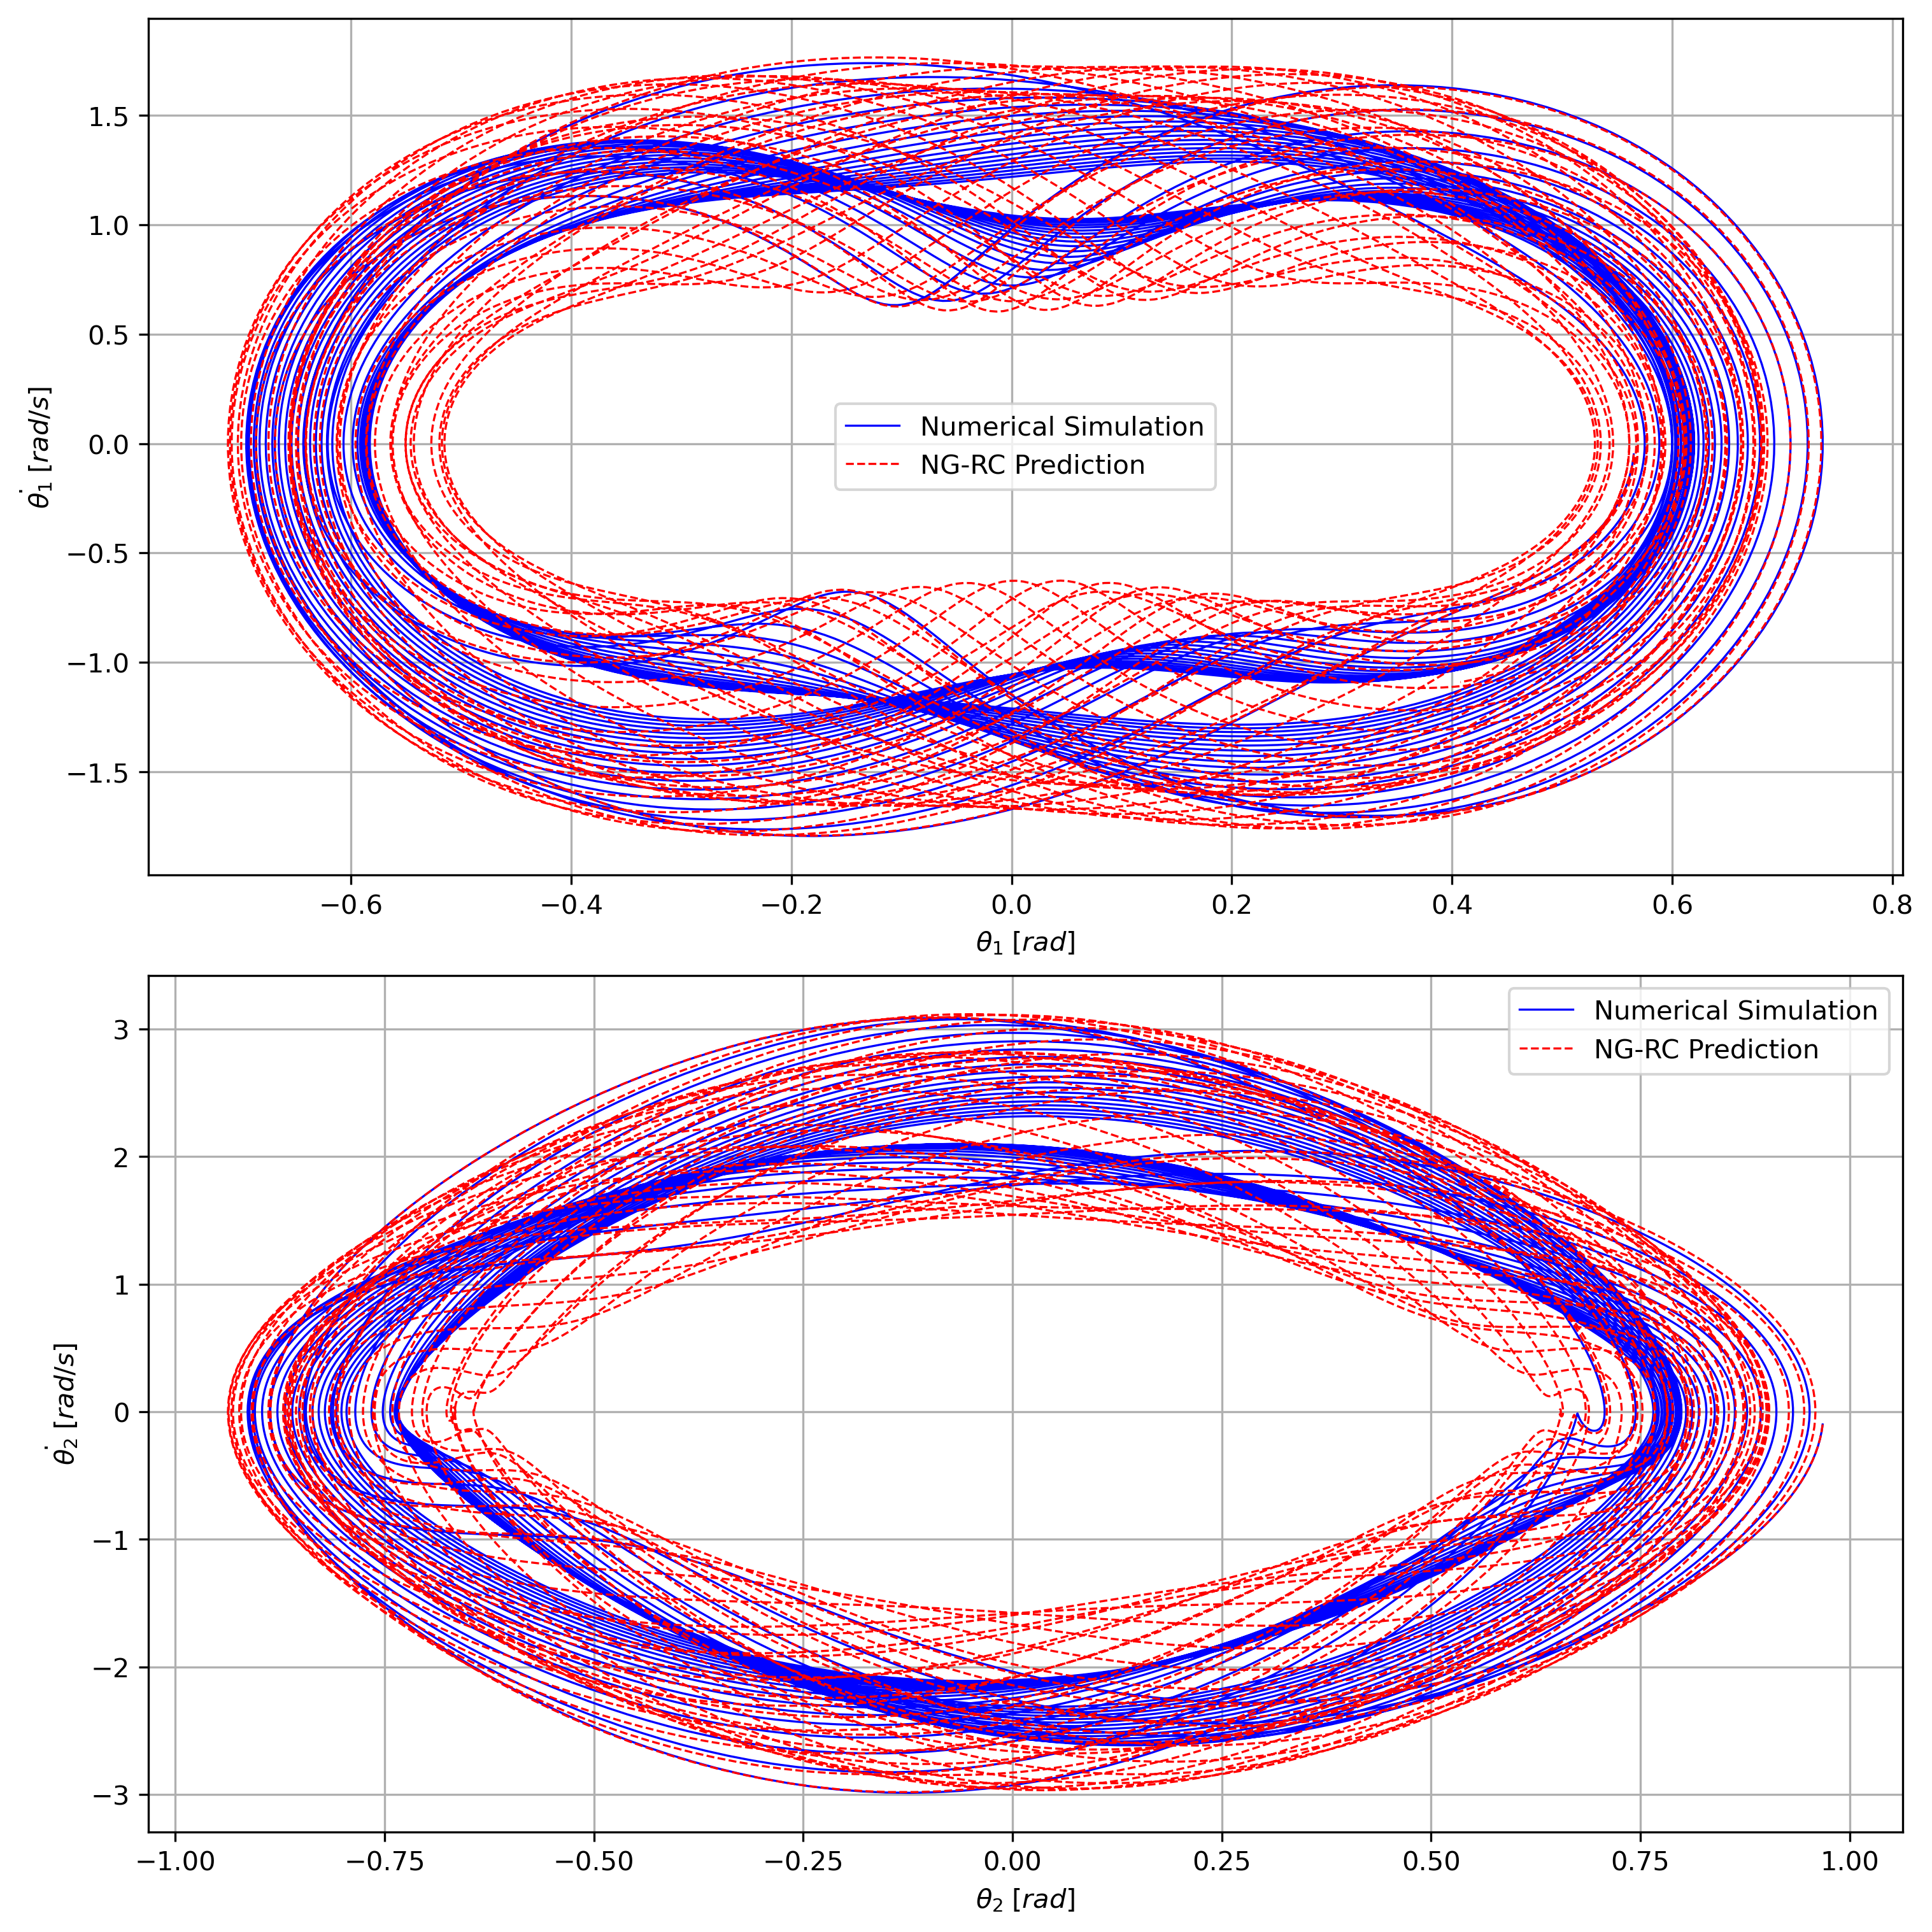

In [28]:
labels_full = [r"$\theta_1 \; [rad]$", r"$\dot{\theta_1} \; [rad/s]$", r"$\theta_2 \; [rad]$", r"$\dot{\theta_2} \; [rad/s]$"]

plot_comparison = plot_comparison_only_testing(y_true_test, y_pred_test, t_test, labels_full)

labels_scatter = [labels_full[0], labels_full[2]]
properties_scatter_idx = [0, 2]
plot_scatter_comparison = plot_scatter_comparison_only_testing(y_true_test, y_pred_test, properties_scatter_idx, labels_scatter)

labels_phase = [
    [labels_full[0], labels_full[1]], 
    [labels_full[2], labels_full[3]]
]
properties_phase_idx = [
    [0, 1], 
    [2, 3]
]
plot_phase_comparison = plot_phase_comparison_only_testing( y_true_test, y_pred_test, properties_phase_idx, labels_phase)